## Pseudobulk visualization

Now we have all the ingredients we need to generate the pseudobulk files to compare the cell types. With this function we will generate fragments files per group and the corresponding bigwigs in general. 

Here, we prepared another function which use the matrix instead of fragments.

In [1]:
import omicverse as ov
import scanpy as sc
import Epiverse as ev
ov.utils.ov_plot_set()

2023-08-30 13:51:33.416156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 13:51:38.975060: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-30 13:51:38.976127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-30 13:51:38.976166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of multiome dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD]. 

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [ ]:
# !mkdir data/
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_atac.h5ad -O data/cd34_multiome_atac.h5ad # ATAC data

In [2]:
adata=sc.read('cd34_multiome_atac_anno.h5ad')
adata

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'peaktype', 'neargene'
    uns: 'celltype_colors'
    obsm: 'X_svd', 'X_umap'

We require peaks to be expressed in at least 0.01% of the cells.

In [3]:
sc.pp.filter_genes(adata, min_cells = adata.shape[0]*0.01)
adata

filtered out 111070 genes that are detected in less than 68.81 cells


AnnData object with n_obs × n_vars = 6881 × 135043
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'peaktype', 'neargene', 'n_cells'
    uns: 'celltype_colors'
    obsm: 'X_svd', 'X_umap'

## Load chromsizes

In order to produce the bigwig files, we also need to know the overall size of the chromosomes. We can easily download this information from the UCSC.

In [4]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

## Analysis the pseudobulk of each celltypes

We provide the `ev.single.pseudobulk` function to get a bigwig file for each cell type from the matrix

In [5]:
ev.single.pseudobulk(adata,chromsizes,cluster_key='celltype',
           clusters=['HSC','MEP','Ery'],
           chr=['seqnames','start','end'],
           bigwig_path='temp')

['HSC', 'MEP', 'Ery']
HSC chr_value
HSC chr_start
HSC chr_end
HSC Name
HSC Score
HSC write
MEP chr_value
MEP chr_start
MEP chr_end
MEP Name
MEP Score
MEP write
Ery chr_value
Ery chr_start
Ery chr_end
Ery Name
Ery Score
Ery write


## Visualization pseudobulk

We can use the bigwig visualisation in the bulk step to analyse the pseudobulk generated by scATAC

In [14]:
bw_dict={
    'Ery':'temp/Ery.bw',
    'HSC':'temp/HSC.bw',
    'MEP':'temp/MEP.bw',
}
bw_obj=ev.bulk.bigwig(bw_dict)
bw_obj.read()

......Loading Ery
......Loading HSC
......Loading MEP


In [15]:
color_dict=dict(zip(adata.obs['celltype'].cat.categories,adata.uns['celltype_colors']))

The gtf files could be downloaded from [gencode](https://www.gencodegenes.org/).

Here, we using GRCh38 v43 to perfrom the annotation.


In [ ]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.basic.annotation.gtf.gz

In [17]:
bw_obj.load_gtf('/mnt/home/zehuazeng/data/gtf/gencode.v43.basic.annotation.gtf')

......Loading gtf file


(<Figure size 480x192 with 4 Axes>,
 array([<AxesSubplot: ylabel='Ery'>, <AxesSubplot: ylabel='HSC'>,
        <AxesSubplot: ylabel='MEP'>, <AxesSubplot: >], dtype=object))

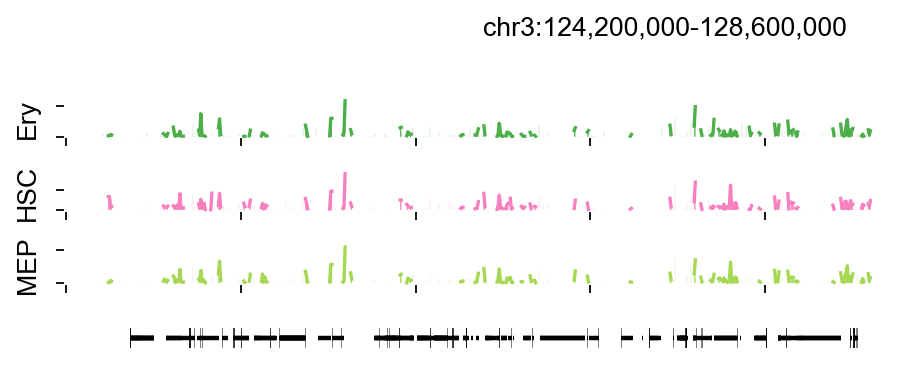

In [20]:
bw_obj.plot_track(chrom='chr3',chromstart=124200000,chromend=128600000,
                  plot_names=['Ery','HSC','MEP'],figwidth=6,figheight=0.6,
                  color_dict=color_dict,
                  #region_dict=region_dict
                 )